## Loading The Required Libraries

In [41]:
import pandas as pd
import requests
from io import StringIO
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import networkx.algorithms.community as nx_comm
from collections import defaultdict
from operator import itemgetter
from networkx.algorithms import community
from networkx.algorithms import link_analysis

## Loading The Dataset From GitHub

In [3]:
github_username = 'amr-mnrashad'
repository_name = 'SNA-Thesis-Project'
api_url = f'https://api.github.com/repos/{github_username}/{repository_name}/contents/Dataset'

- The aim of the following code is to load the csv files stored in my GitHub repository and store them in a single dataframe called 'merged_df'.
- There is the option to select the number of rows or the number of csv files desired to be stored in the dataframe. The reason is I was interested in doing some trials on a smaller dataset size

In [4]:
def load_csv_from_github(file_url):
    response = requests.get(file_url)
    if response.status_code == 200:
        content = response.content
        df = pd.read_csv(StringIO(content.decode('utf-8')))
        return df.head(1000)  # Number of rows desired to take from each csv file
    else:
        print(f"Failed to fetch {file_url}")
        return None

response = requests.get(api_url)
if response.status_code == 200:
    content = response.json()
    print("Files in Dataset directory:")
    dfs = []  # Initializing an empty list to store dataframes of each csv file
    count = 0  # Initializing a counter to keep track of the processed files
    for file_info in content:
        print(file_info['name'])
        if file_info['name'].endswith('.csv'):
            csv_url = file_info['download_url']
            df = load_csv_from_github(csv_url)
            if df is not None:
                dfs.append(df)
                count += 1
                if count >= 100:  # Number of csv files desired to store in my dataframe
                    break
else:
    print(f"Failed to fetch directory contents. Status code: {response.status_code}")

# Concatenating all dataframes into a single one to make it easier for me to do some data preprocessing
if dfs:
    merged_df = pd.concat(dfs, ignore_index=True)
    print("Merging successful.")
else:
    print("No CSV files found in the Dataset directory.")

Files in Dataset directory:
AdviceAnimals_data.csv
AmItheAsshole_data.csv
AnimalsBeingBros_data.csv
AnimalsBeingDerps_data.csv
AnimalsBeingJerks_data.csv
Art_data.csv
AskReddit_data.csv
AskWomen_data.csv
Awwducational_data.csv
BeAmazed_data.csv
Bitcoin_data.csv
BlackPeopleTwitter_data.csv
ContagiousLaughter_data.csv
CryptoCurrency_data.csv
DIY_data.csv
Damnthatsinteresting_data.csv
Documentaries_data.csv
EarthPorn_data.csv
EatCheapAndHealthy_data.csv
Fitness_data.csv
FoodPorn_data.csv
Futurology_data.csv
GetMotivated_data.csv
HistoryMemes_data.csv
IAmA_data.csv
InternetIsBeautiful_data.csv
Jokes_data.csv
LifeProTips_data.csv
MadeMeSmile_data.csv
Minecraft_data.csv
Music_data.csv
NatureIsFuckingLit_data.csv
OldSchoolCool_data.csv
PS4_data.csv
Parenting_data.csv
Showerthoughts_data.csv
Tinder_data.csv
TwoXChromosomes_data.csv
Unexpected_data.csv
UpliftingNews_data.csv
WTF_data.csv
WatchPeopleDieInside_data.csv
Whatcouldgowrong_data.csv
WritingPrompts_data.csv
anime_data.csv
askscience_da

## Creating Graph Dataframe

- The aim of this section is to create a clean dataframe that will be used to create my networkx graph. The dataframe created is graph_df.
- A new column is created which stores users who posted and users who commented into a single list. If the user who posted also commented, then only one unique ID will be in the list, as I have removed duplicates.
- Other columns have been dropped such as 'Downvotes' column and 'User ID' and 'Users Who Commented'
- graph_df is a copy of the cleaned merged_df, in order to ensure that graph_df is independent

In [12]:
merged_df.head()

,Subreddit,Population,Post Title,User ID,Users Who Commented,Upvotes,Date,Time,Downvotes
0,AdviceAnimals,9834809,It’s really not that hard to figure out,TwoPercentTokes,"jezra,alejo699,TrinixDMorrison,squeeeeenis,myc...",97106,2022-08-31,22:03:49,NaN
1,AdviceAnimals,9834809,Chrome says that they're no longer allowing ad...,ElderCunningham,"chrysrobyn,lotsofdeadkittens,Tony_Cheese_,Squa...",86334,2022-08-24,18:27:29,NaN
2,AdviceAnimals,9834809,"EU, plz gib more monies...",bamamabuam,"trystanthorne,guspaz,TheMacroorchidism,craftwo...",71850,2023-02-09,17:27:19,NaN
3,AdviceAnimals,9834809,Just be safe.,ohnodopey,"doxamully,ratcliffeb,MisssJaynie,LegendOfBobby...",70897,2022-12-31,17:42:26,NaN
4,AdviceAnimals,9834809,Major “breastfed until they were eight” energy,SoylentCreek,"Red_Carrot,ken27238,Cold_Kaleidoscope354,TheFu...",68948,2023-06-10,01:40:24,NaN


In [13]:
def create_graph_dataframe(df):     
  # Removing 'AutoModerator' from 'Users Who Commented' column as it doesn't describe the behavior of a typical/normal user
  df = df.dropna(subset=['Users Who Commented'])
  df = df.dropna(subset=['User ID'])
  df['Users Who Commented'] = df['Users Who Commented']\
                                .apply(lambda users: ','.join([user.strip() for user in users.split(',') if user.strip() != 'AutoModerator']) if isinstance(users, str) else users)
  df['Subreddit_Users'] = df.apply(lambda row: (row['User ID'] + ',' + row['Users Who Commented'])\
                                                                      .strip(',') if row['User ID'] != 'AutoModerator' else row['Users Who Commented'], axis=1)
  df = df.rename(columns={'Post Title': 'Post_Title'})
  df['Users_List'] = df['Subreddit_Users'].str.split(',')
  df = df.drop(columns=['Downvotes', 'User ID', 'Users Who Commented', 'Subreddit_Users'])
  df = df.dropna(subset=['Users_List'])
  df['Users_List'] = df['Users_List'].apply(lambda users_list: list(set(users_list))) 
  G_df = df.copy()
  return G_df

In [14]:
graph_df = create_graph_dataframe(merged_df)
graph_df.head()

,Subreddit,Population,Post_Title,Upvotes,Date,Time,Users_List
0,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,22:03:49,"[Xraptorx, Boristhehostile, SnazzyStooge, Sean..."
1,AdviceAnimals,9834809,Chrome says that they're no longer allowing ad...,86334,2022-08-24,18:27:29,"[mr_hellmonkey, Glomgore, NegativeDuck8216, De..."
2,AdviceAnimals,9834809,"EU, plz gib more monies...",71850,2023-02-09,17:27:19,"[entered_bubble_50, homeofmatt, Antonioshamstr..."
3,AdviceAnimals,9834809,Just be safe.,70897,2022-12-31,17:42:26,"[TootieSummers, clycloptopus, moondes, catmech..."
4,AdviceAnimals,9834809,Major “breastfed until they were eight” energy,68948,2023-06-10,01:40:24,"[vahntitrio, 13ulbasaur, Top_Account3643, Mcba..."


- After creating graph_df, due to the large size of the dataset, I decided to keep only the active user Ids in the 'Users_List' column, by active I mean a user ID that appears at least 40 times in a subreddit group. Example User A appears 40 times in Subreddit X, meaning the user ID is listed in 40 rows where the subreddit column value is X.
- Few trials have been made to establish what could an optimal threshold that would result in a large enough dataset that can be processed on a single machine. I started with 100 and went down to 10 gradually, however the best one that results in a good dataset size and graph size as well is 40.

In [15]:
# Aim of this function is to return the list of active users
def filter_users(users_list, subreddit):
    active_users_subreddit = set(active_users[active_users['Subreddit'] == subreddit]['Users_List'].tolist())
    return list(set(users_list) & active_users_subreddit)  # Use set intersection to remove duplicates

In [16]:
# Here I count the occurrences of each user ID in a subreddit
user_counts = graph_df.explode('Users_List').groupby(['Users_List', 'Subreddit']).size().reset_index(name='Count')
# Here I identify the users who appear at least 40 times in a subreddit
active_users = user_counts[user_counts['Count'] >= 40]
#Then I perform the filteration and just keep the active users in my 'Users_List' column
graph_df['Users_List'] = graph_df.apply(lambda row: filter_users(row['Users_List'], row['Subreddit']), axis=1)
# If the Users_List is empty I drop the row
graph_df = graph_df[graph_df['Users_List'].map(len) > 0]
graph_df.head()

,Subreddit,Population,Post_Title,Upvotes,Date,Time,Users_List
0,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,22:03:49,"[Lost-My-Mind-, SgtDoughnut, JasonDJ, tacknosa..."
1,AdviceAnimals,9834809,Chrome says that they're no longer allowing ad...,86334,2022-08-24,18:27:29,"[imakenosensetopeople, SgtDoughnut, foggy-sunr..."
2,AdviceAnimals,9834809,"EU, plz gib more monies...",71850,2023-02-09,17:27:19,"[TestPattern2, redpandaeater, WikiSummarizerBo..."
3,AdviceAnimals,9834809,Just be safe.,70897,2022-12-31,17:42:26,"[Lost-My-Mind-, The_Running_Free, Mccobsta, Al..."
4,AdviceAnimals,9834809,Major “breastfed until they were eight” energy,68948,2023-06-10,01:40:24,"[Randvek, All_Work_All_Play, PillowTalk420]"


## Creating Graph

- The aim of this part is to create my undirected graph from graph_df. Where The user ids in my 'Users_List' column are my nodes and two users would be linked together if they have been active on a common subreddit, the word active here means either posted or commented.

In [10]:
def create_graph(df):
    G = nx.Graph()

    # Here I start by adding the nodes to my empty graph
    for index, row in df.iterrows():
        users = row['Users_List']
        for user in users:
            G.add_node(user)

    print("Nodes are added to the graph successfully")

    # Here I start by Adding edges to the graph based on the subreddit interactions
    for subreddit in df['Subreddit'].unique():
        subreddit_users = df[df['Subreddit'] == subreddit]['Users_List']
        for users_list in subreddit_users:
            for user1 in users_list:
                for user2 in users_list:
                    if user1 != user2:
                        G.add_edge(user1, user2, subreddit=subreddit)

    print("Edges are added to the graph successfully")

    return G

In [18]:
subreddits_graph = create_graph(graph_df)

Nodes are added to the graph successfully
Edges are added to the graph successfully


In [20]:
num_nodes = subreddits_graph.number_of_nodes()
num_edges = subreddits_graph.number_of_edges()

print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

Number of nodes in the graph: 8587
Number of edges in the graph: 1375357


- Here I check if my graph is connected and forms one single component or does it contain subgraphs.

In [21]:
connected_components = list(nx.connected_components(subreddits_graph))
print("Nodes in each connected component:")
for i, component in enumerate(connected_components, start=1):
    print(f"Connected Component {i}: {component}")

Nodes in each connected component:
Connected Component 1: {'becomingstronger', 'el_LOU', 'yhwhx', 'Zach202020', 'Cute_Set_2680', '-KFBR392', 'mumofboys86', 'omgFWTbear', 'vattenj', 'ItsMrDante', 'KingofTheTorrentine', 'CuteGuyInNorCal', 'aamgdp', 'WhyDoName', 'deftspyder', 'Sinnester888', 'Ult1mateN00B', 'joanzen', 'Ok-Bridge-1045', 'Western-Image7125', 'SoftPenguins', 'code_archeologist', 'Kindly_Sky9167', 'leli_manning', 'Galilleon', 'zykezero', 'KANJI667', 'RosemaryFocaccia', 'pdubbs87', 'La_danse_banana_slug', 'PrinceZukoBlueFire', 'wtfduud', 'SuvenPan', 'RoyalArmyBeserker', 'Ludwigofthepotatoppl', 'North_Atlantic_Pact', 'VincentBlack96', 'RavenLunatyk', 'Riegel_Haribo', 'miniminer1999', 'Lyress', 'socokid', 'Dare555', 'thy_armageddon', 'Midwest_Rell', 'Blade_Shot24', 'StormR7', 'Maleficent_Plankton', 'junkit33', 'SuperFLEB', 'OK_Renegade', 'chicago_bunny', 'Revolutionary-Help68', 'Forever__Young', 'Bebi-Cat', 'flak0u', 'QuirkyAverageJoe', 'Corfiz74', 'lobstahpotts', 'TerminatorReb

- Knowing that I have my graph is composed of 5 components, and three of them are considered to be very small, I am going to focus only on the first components and consider it to be my main graph as it contains most of the nodes and edges. This is done over 3 main steps.

In [22]:
# Step 1: Finding the connected components
connected_components = list(nx.connected_components(subreddits_graph))
# Step 2: Getting the nodes in component 1 (first component in the list)
nodes_component_1 = connected_components[0]
# Step 3: Creating a new graph with only nodes and edges from component 1
subreddits_graph = subreddits_graph.subgraph(nodes_component_1)
# Printing the number of nodes and edges in the connected graph (component 1)
print("Number of nodes in the connected graph (component 1):", len(subreddits_graph.nodes()))
print("Number of edges in the connected graph (component 1):", len(subreddits_graph.edges()))

Number of nodes in the connected graph (component 1): 8513
Number of edges in the connected graph (component 1): 1373559


## Network Analysis

In [102]:
#Few network statistics
degree = subreddits_graph.degree
subreddits_graph_degree_dict = dict(subreddits_graph.degree)
subreddits_graph_degree_list = list(dict(subreddits_graph.degree()).values())
density = nx.density(subreddits_graph)
subreddits_degree_view=subreddits_graph.degree()
subreddits_degree=list(dict(subreddits_graph.degree()).values())
average_shortest_path = nx.average_shortest_path_length(subreddits_graph)

print("Mean: ", np.mean(subreddits_graph_degree_list))
print("Median: ",np.median(subreddits_graph_degree_list))
print("Standard deviation: ",np.std(subreddits_graph_degree_list))
print("Max: ",np.max(subreddits_graph_degree_list))
print("Min: ",np.min(subreddits_graph_degree_list))
print('Network Density: ', density)
print('transitivity: {}'.format(nx.transitivity(subreddits_graph)))
print('Average shortest path: ', average_shortest_path)

Mean:  322.69681663338423
Median:  283.0
Standard deviation:  232.17531625818404
Max:  2024
Min:  1
Network Density:  0.03791081022478668
transitivity: 0.8883913932643737
Average shortest path:  2.588987408907562


Text(0, 0.5, 'ECCDF')

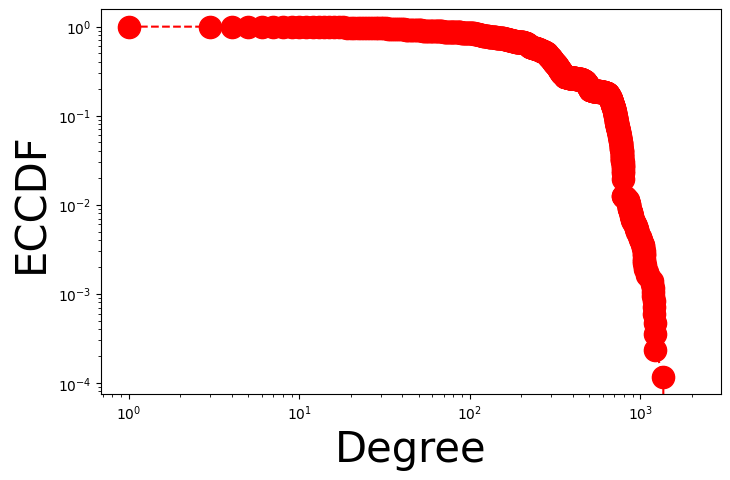

In [103]:
cdf_function = ECDF(subreddits_degree)
x = np.unique(subreddits_degree)
# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,5))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'red', linestyle = '--', marker= 'o',ms = 16)
axes.set_xlabel('Degree',size = 30)
axes.set_ylabel('ECCDF',size = 30)

In [104]:
percentile_95 = np.percentile(subreddits_degree,95)
hub_nodi = [k for k,v in dict(subreddits_graph.degree()).items() if v>= percentile_95]

print("Percentile_95: ", percentile_95)
print("hub_nodi: ", hub_nodi)
print('dictionary keyed by nodes: number of triangles {}'.format(nx.triangles(subreddits_graph)))
print('local clustering: {}'.format(nx.clustering(subreddits_graph)))
print('Average clustering coefficient: ', nx.average_clustering(subreddits_graph), np.mean(list(nx.clustering(subreddits_graph).values())))

Percentile_95:  766.0
hub_nodi:  ['Technologhee', 'socokid', 'Here_for_tea_', 'aLittleQueer', 'gsfgf', 'Explodicle', 'Double-LR', 'Rey_Mezcalero', 'KAX1107', 'TheGreatest34567', 'kwanijml', 'JerryLeeDog', 'Walla_Walla_26', 'sylsau', 'Outrageous_Duty_8738', 'Dazzling_Marzipan474', 'Rtbrosk', 'Zealousideal_Neck78', 'bobbyv137', 'zesushv', 'xof711', 'bittabet', 'Jin-Sakti', 'sebikun', 'coinfeeds-bot', 'EarningsPal', 'Hank___Scorpio', 'fnetma', 'bitcoin_islander', 'ChrysMYO', 'Ok_Skill_1195', 'DLottchula', 'FuckingKilljoy', 'kekehippo', 'Canesjags4life', 'ClaymoresRevenge', 'TheMoorNextDoor', 'LyonsKing12', 'Toast2Carnage', 'DDDUnit2990', 'meeleen223', 'andmind', 'Lillica_Golden_SHIB', 'deathbyfish13', 'Cactuszach', 'genjitenji', 'TarkovReddit0r', 'Thump604', 'princepersona1', 'MaeronTargaryen', 'ShotCryptographer523', 'unitys2011', 'forceworks', 'bny192677', 'H__Dresden', 'DreadknotX', 'Connect_Fee1256', 'Cheese6260', 'evoxyseah', 'suninabox', 'Odlavso', 'BrocoliAssassin', 'ChemicalGreek'

In [105]:
# Centrality
sorted_degree = sorted(subreddits_graph_degree_dict.items(), key = itemgetter(1), reverse= True)
print('Top 10 nodes by degree:')
for i in sorted_degree[:10]:
    print(i)

Top 10 nodes by degree:
('why_rob_y', 2024)
('sevaiper', 1363)
('dimmyfarm', 1226)
('sorendiz', 1220)
('AtreusIsBack', 1219)
('cheerioo', 1205)
('esports_consultant', 1204)
('AlHorfordHighlights', 1197)
('salcedoge', 1189)
('lovo17', 1188)


In [107]:
betweeness_dict = nx.betweenness_centrality(subreddits_graph)
#Adding the values of the centralities as attributes in the network's nodes
nx.set_node_attributes(subreddits_graph, betweeness_dict, 'betweeness')

eigenvector_dict = nx.eigenvector_centrality(subreddits_graph)
nx.set_node_attributes(subreddits_graph, eigenvector_dict, 'eigenvector')

sorted_betweeness = sorted(betweeness_dict.items(), key= itemgetter(1), reverse= True)
print('Top 10 nodes by betweeness centrality: ')
for i in sorted_betweeness[:10]:
    print(i)

Top 10 nodes by betweeness centrality: 
('why_rob_y', 0.057970543210624344)
('nucumber', 0.042528046385602404)
('HaikuBotStalksMe', 0.02964110783958325)
('aLittleQueer', 0.025440785233682314)
('duaneap', 0.02376721068784132)
('aeiou-y', 0.020209100350476537)
('cheesypuzzas', 0.017606537059705097)
('Ok_Skill_1195', 0.017447537684424527)
('sevaiper', 0.016773862712007818)
('caninehere', 0.014211446167219215)


## Community Detection

- The aim of this section is to perform two techniques, Greedy Algorithm & Louvain Algorithm. Then I evaluate both techniques and observe which one results in a higher modularity score and use it as my main technique to create my communities.

### Modularity Maximization - Greedy Algorithm

In [65]:
list_community_sets_greedy = list(nx_comm.greedy_modularity_communities(subreddits_graph))
print(list_community_sets_greedy)

[frozenset({'brezhnervous', 'mel2000', 'yousyveshughs', 'inksmudgedhands', 'infinitevariables', 'Fynn_the_Finger', 'Impressive-Potato', 'jujotheconquerer', 'MaimedJester', 'SANAFABICH', 'Embarrassed_Alarm450', 'Podo13', 'MeanGreanHare', 'Reefer-eyed_Beans', 'HauntedCemetery', 'Feral0_o', 'wolves_hunt_in_packs', 'EFT_Syte', 'ArtisanJagon', 'ImprovedPersonality', 'VagrantShadow', 'caboosetp', 'ascagnel____', 'Valiantheart', 'Vast_Reflection', 'Maximum-Mixture6158', 'dominantspecies', 'rcc12697', 'VaATC', 'Porrick', 'bloodyturtle', 'dumnezero', 'Drachefly', 'Missing_Trillions', 'NextPower6327', '_PM_ME_PANGOLINS_', 'meatball402', 'HandLion', 'MauiWowieOwie', 'incasesheisonheretoo', 'LostWoodsInTheField', 'u9Nails', 'RyVsWorld', 'No___ImRight', '2x4x93', 'Sariel007', 'Brewtality76', 'giuliomagnifico', 'ignost', 'ArchDucky', 'DoubleAholeTwice', 'FlamingTrollz', 'Scrimshawmud', 'thelingeringlead', 'InGordWeTrust', 'Art-Zuron', 'McFeely_Smackup', 'Blue_Swirling_Bunny', '249ba36000029bbe9749',

In [66]:
partition_greedy = {}
for i, comm in enumerate(list_community_sets_greedy):
    print('Community:', i)
    print(i, comm) #printing the list of nodes that belong to each community
    for n in comm:
        partition_greedy[n] = i

Community: 0
0 frozenset({'brezhnervous', 'mel2000', 'yousyveshughs', 'inksmudgedhands', 'infinitevariables', 'Fynn_the_Finger', 'Impressive-Potato', 'jujotheconquerer', 'MaimedJester', 'SANAFABICH', 'Embarrassed_Alarm450', 'Podo13', 'MeanGreanHare', 'Reefer-eyed_Beans', 'HauntedCemetery', 'Feral0_o', 'wolves_hunt_in_packs', 'EFT_Syte', 'ArtisanJagon', 'ImprovedPersonality', 'VagrantShadow', 'caboosetp', 'ascagnel____', 'Valiantheart', 'Vast_Reflection', 'Maximum-Mixture6158', 'dominantspecies', 'rcc12697', 'VaATC', 'Porrick', 'bloodyturtle', 'dumnezero', 'Drachefly', 'Missing_Trillions', 'NextPower6327', '_PM_ME_PANGOLINS_', 'meatball402', 'HandLion', 'MauiWowieOwie', 'incasesheisonheretoo', 'LostWoodsInTheField', 'u9Nails', 'RyVsWorld', 'No___ImRight', '2x4x93', 'Sariel007', 'Brewtality76', 'giuliomagnifico', 'ignost', 'ArchDucky', 'DoubleAholeTwice', 'FlamingTrollz', 'Scrimshawmud', 'thelingeringlead', 'InGordWeTrust', 'Art-Zuron', 'McFeely_Smackup', 'Blue_Swirling_Bunny', '249ba360

In [67]:
nx.set_node_attributes(subreddits_graph, partition_greedy, 'Subreddit_comm_greedy')

### Modularity Maximization - Louvain Algorithm

In [23]:
partition_library = community_louvain.best_partition(subreddits_graph)
print(partition_library)

{'Lost-My-Mind-': 0, 'SgtDoughnut': 1, 'JasonDJ': 1, 'tacknosaddle': 1, 'jezra': 1, 'Cereborn': 1, 'Killbot_Wants_Hug': 1, 'sloopslarp': 0, 'Randvek': 1, 'Seiglerfone': 1, 'imakenosensetopeople': 1, 'foggy-sunrise': 0, 'boxsterguy': 2, 'DigNitty': 3, 'TestPattern2': 1, 'redpandaeater': 1, 'WikiSummarizerBot': 2, 'LeoMarius': 1, 'donorak7': 1, '444unsure': 1, 'The_Running_Free': 1, 'Mccobsta': 1, 'All_Work_All_Play': 0, 'Thendofreason': 1, 'GopnikSmegmaBBQSauce': 1, 'SilentSamurai': 1, 'PillowTalk420': 2, 'zaphodava': 1, 'Black_Moons': 1, 'Technologhee': 5, 'MathMaddox': 1, 'temalyen': 1, 'Purplociraptor': 1, 'socokid': 0, 'westwoo': 1, 'spagbetti': 1, 'processedmeat': 1, 'nubsauce87': 1, 'ActualMis': 1, '4Ever2Thee': 1, 'Boggie135': 3, 'mortalcoil1': 1, '3-DMan': 1, '4RCH43ON': 1, 'occamsrzor': 1, 'monjoe': 6, 'infinitevariables': 1, 'metaStatic': 1, 'Geminii27': 1, 'Gorstag': 0, 'snoandsk88': 1, 'TheMooseIsBlue': 1, 'G8kpr': 1, 'Grymbaldknight': 1, 'pwalkz': 1, 'Piemaster113': 1, 'N8C

In [24]:
nx.set_node_attributes(subreddits_graph, partition_library, 'community_library')

### Evaluating The Communities

In [70]:
Subreddit_communities = set(partition_library.values())
Subreddit_communities

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [71]:
list_community_sets_louvain = [set() for i in range(len(Subreddit_communities))]
for n, Subreddit_communities in partition_library.items():
    list_community_sets_louvain[Subreddit_communities].add(n)

list_community_sets_louvain

[{'brezhnervous',
  'mel2000',
  'yousyveshughs',
  'inksmudgedhands',
  'infinitevariables',
  'Fynn_the_Finger',
  'Impressive-Potato',
  'jujotheconquerer',
  'MaimedJester',
  'SANAFABICH',
  'Embarrassed_Alarm450',
  'Podo13',
  'MeanGreanHare',
  'Reefer-eyed_Beans',
  'HauntedCemetery',
  'Feral0_o',
  'wolves_hunt_in_packs',
  'EFT_Syte',
  'ArtisanJagon',
  'ImprovedPersonality',
  'VagrantShadow',
  'caboosetp',
  'ascagnel____',
  'Valiantheart',
  'Vast_Reflection',
  'Maximum-Mixture6158',
  'dominantspecies',
  'rcc12697',
  'VaATC',
  'beldaran1224',
  'Porrick',
  'farseer4',
  'bloodyturtle',
  'Drachefly',
  'dumnezero',
  'Missing_Trillions',
  'NextPower6327',
  '_PM_ME_PANGOLINS_',
  'meatball402',
  'HandLion',
  'MauiWowieOwie',
  'incasesheisonheretoo',
  'LostWoodsInTheField',
  'u9Nails',
  'RyVsWorld',
  'No___ImRight',
  '2x4x93',
  'giuliomagnifico',
  'ArchDucky',
  'ignost',
  'DoubleAholeTwice',
  'Scrimshawmud',
  'FlamingTrollz',
  'McFeely_Smackup',
 

In [72]:
for my_list in [list_community_sets_greedy, list_community_sets_louvain]:
    #Modularity
    print('Modularity: ', nx_comm.modularity(subreddits_graph, my_list, weight= 'weight'))
    print('---')

Modularity:  0.8070385945585606
---
Modularity:  0.833536663781477
---


### Distribution Size Of The Communities

In [73]:
pairs = []
for i, nodes in enumerate(list_community_sets_louvain):
    print(i, len(nodes))
    comm_size = (i, len(nodes))
    pairs.append(comm_size)

0 2369
1 36
2 390
3 353
4 793
5 232
6 548
7 289
8 154
9 398
10 284
11 333
12 150
13 106
14 213
15 728
16 125
17 340
18 498
19 174


In [74]:
community_index = []
number_of_nodes = []

for Subreddit_communities, n_nodes in pairs:
    community_index.append(str(Subreddit_communities))
    number_of_nodes.append(n_nodes)

Text(0, 0.5, 'Number of Nodes')

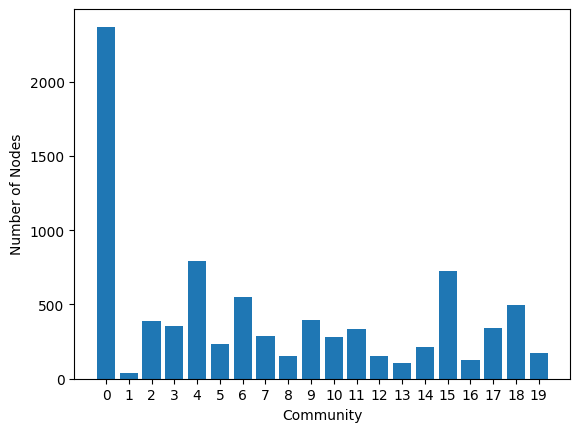

In [75]:
plt.bar(community_index, number_of_nodes)
plt.xlabel('Community')
plt.ylabel('Number of Nodes')

### Centrality in Communities

In [76]:
centr_comm = {}
for comm in list_community_sets_louvain:
    subgraph = subreddits_graph.subgraph(comm)
    print(subgraph.order())
    print(nx.degree_centrality(subgraph))
    print('---')

2369
{'brezhnervous': 0.053209459459459464, 'mel2000': 0.0477195945945946, 'yousyveshughs': 0.00971283783783784, 'inksmudgedhands': 0.10895270270270271, 'infinitevariables': 0.033783783783783786, 'Fynn_the_Finger': 0.13640202702702703, 'Impressive-Potato': 0.052787162162162164, 'jujotheconquerer': 0.030827702702702704, 'MaimedJester': 0.1097972972972973, 'SANAFABICH': 0.03589527027027027, 'Embarrassed_Alarm450': 0.00971283783783784, 'Podo13': 0.10853040540540541, 'MeanGreanHare': 0.024915540540540543, 'Reefer-eyed_Beans': 0.00633445945945946, 'HauntedCemetery': 0.21790540540540543, 'Feral0_o': 0.09881756756756757, 'wolves_hunt_in_packs': 0.041385135135135136, 'EFT_Syte': 0.12922297297297297, 'ArtisanJagon': 0.125, 'ImprovedPersonality': 0.04054054054054054, 'VagrantShadow': 0.08868243243243244, 'caboosetp': 0.011402027027027029, 'ascagnel____': 0.1102195945945946, 'Valiantheart': 0.10304054054054054, 'Vast_Reflection': 0.02702702702702703, 'Maximum-Mixture6158': 0.04434121621621622, 'd

In [77]:
centr_comm = {}
for comm in list_community_sets_louvain:
    subgraph = subreddits_graph.subgraph(comm)
    node_degrees = nx.degree_centrality(subgraph)
    for n, d in node_degrees.items():
        centr_comm[n] = d

In [78]:
nx.set_node_attributes(subreddits_graph, centr_comm, 'centr_comm')

In [79]:
sorted_centr_comm = sorted(centr_comm.items(), key= itemgetter(1), reverse= True)
print('Top 10 nodes by betweeness centrality: ')
for i in sorted_centr_comm[:5000]:
    print(i)

Top 10 nodes by betweeness centrality: 
('TheFinalDawnYT', 1.0)
('sadnesslaughs', 1.0)
('armageddon_20xx', 1.0)
('MolhCD', 1.0)
('GrunkleStanwhich', 1.0)
('NotAMeatPopsicle', 1.0)
('SilasCrane', 1.0)
('stealthcake20', 1.0)
('MrRedoot55', 1.0)
('Phoenix4235', 1.0)
('MechisX', 1.0)
('SirPiecemaker', 1.0)
('S1eepyZ', 1.0)
('Weird-Ingenuity97', 1.0)
('Darqnyz', 1.0)
('Merchantmarx', 1.0)
('thelegalseagul', 1.0)
('DudeEngineer', 1.0)
('FEMA_Camp_Survivor', 1.0)
('treetyoselfcarol', 1.0)
('Davethisisntcool', 1.0)
('Zetice', 1.0)
('H-TownDown', 1.0)
('cologne_peddler', 1.0)
('JennyBeckman', 1.0)
('Bunnnnii', 1.0)
('Ok_Skill_1195', 1.0)
('FistPunch_Vol_4', 1.0)
('CKIMBLE4', 1.0)
('srkaficionado', 1.0)
('LDcostict', 1.0)
('bkwilcox100', 1.0)
('vera214usc', 1.0)
('kahran', 1.0)
('Sleep-system', 1.0)
('Aaaandiiii', 1.0)
('CoachDT', 1.0)
('Bubbly_Satisfaction2', 1.0)
('KingJoy79', 1.0)
('BlackySmurf8', 1.0)
('MelaninTitan', 1.0)
('Probably_A_Variant', 1.0)
('blacklite911', 1.0)
('oldcarfreddy', 1.

## PageRank

- The aim here is to calculate the Overall/Community PageRank score of each node to determine the influential nodes in my graph/Community

### Calculating The Overall PageRank Scores

In [81]:
def calculate_pagerank(graph):
    pagerank_scores = nx.pagerank(graph)
    nx.set_node_attributes(graph, pagerank_scores, name='pagerank')
    return graph

In [82]:
subreddits_graph = calculate_pagerank(subreddits_graph)

### Calculating PageRank Scores Within Each Community

In [44]:
for community_id in set(nx.get_node_attributes(subreddits_graph, 'community_library').values()):
    community_nodes = [node for node, comm_id in nx.get_node_attributes(subreddits_graph, 'community_library').items() if comm_id == community_id]
    community_subgraph = subreddits_graph.subgraph(community_nodes)
    pagerank_scores = link_analysis.pagerank_alg.pagerank(community_subgraph)
    for node, score in pagerank_scores.items():
        subreddits_graph.nodes[node]['Pagerank_Within_Community'] = score

### Saving The Graph

In [42]:
nx.write_gexf(G = subreddits_graph, path = 'Final_subreddits_graph.gexf')

## Loading The Final Graph

In [6]:
file_path = 'Final_subreddits_graph.gexf'
# Loading the graph from the .gexf file
subreddits_graph = nx.read_gexf(file_path)
# Double checking the number of nodes and edges after loading both nodes and edges
num_nodes = subreddits_graph.number_of_nodes()
num_edges = subreddits_graph.number_of_edges()

print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

Number of nodes in the graph: 8517
Number of edges in the graph: 1378151


## Creating Nodes Dataframe With Community Labels & PageRank Scores

- The aim of this section is to create the nodes dataframe, where each attribute is stored in a seperate column.

In [46]:
def create_nodes_df(graph):
  nodes_with_attributes = graph.nodes(data=True)
  df = pd.DataFrame(nodes_with_attributes, columns=['Node', 'Attributes'])
  # Splitting the 'Attributes' column into separate columns
  attributes_df = pd.DataFrame(df['Attributes'].tolist(), index=df.index)
  # Concatenating the original 'Node' column and the split attributes columns
  df = pd.concat([df['Node'], attributes_df], axis=1)
  df = df.drop(columns=['label'])
  return df

In [47]:
nodes_df = create_nodes_df(subreddits_graph)
nodes_df.head()

,Node,Subreddit_comm_greedy,community_library,centr_comm,pagerank,betweeness,eigenvector,Pagerank_Within_Community
0,Randvek,0,0,0.034628,0.000076,1.294372e-07,0.000062,0.000293
1,jezra,0,0,0.036740,0.000081,5.138142e-07,0.000062,0.000309
2,SgtDoughnut,0,0,0.075169,0.000137,1.514008e-04,0.000197,0.000528
3,Cereborn,0,0,0.037162,0.000082,5.166568e-07,0.000062,0.000313
4,Killbot_Wants_Hug,0,0,0.037584,0.000082,5.172722e-07,0.000062,0.000315


## Creating The Overall Dataframe

- The aim here is to merge both the nodes dataframe with the graph dataframe that contains the subreddits, post content, users lists...

In [30]:
def exploding_users_list(df):
  exploded_df = df.explode('Users_List')
  exploded_df = exploded_df.rename(columns={'Users_List': 'User_ID'})
  # Reseting the index
  exploded_df.reset_index(drop=True, inplace=True)
  return exploded_df

def create_overall_dataframe(exploded_df, nodes_df):
  df = exploded_df.merge(nodes_df, left_on='User_ID', right_on='Node', how='left')
  df.rename(columns={'community_library': 'Community_Label', 'pagerank': 'PageRank'}, inplace=True)
  # Dropping the redundant 'Node' column
  df.drop(columns=['Node', 'betweeness', 'eigenvector', 'Subreddit_comm_greedy', 'centr_comm', 'Time'], inplace=True)
  # Dropping rows with missing values
  df.dropna(inplace=True)
  # Reseting the index after dropping rows
  df.reset_index(drop=True, inplace=True)
  # Converting 'Community_Label' column to integers
  df['Community_Label'] = df['Community_Label'].astype(int)
  return df

In [48]:
users_exploded_df = exploding_users_list(graph_df)
overall_df = create_overall_dataframe(users_exploded_df, nodes_df)
overall_df.head()

,Subreddit,Population,Post_Title,Upvotes,Date,User_ID,Community_Label,PageRank,Pagerank_Within_Community
0,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,Lost-My-Mind-,0,0.000407,0.001599
1,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,SgtDoughnut,0,0.000137,0.000528
2,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,JasonDJ,0,0.000082,0.000312
3,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,tacknosaddle,0,0.000199,0.000771
4,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,jezra,0,0.000081,0.000309


In [32]:
num_rows = overall_df.shape[0]
print("Number of rows in exploded_df:", num_rows)

Number of rows in exploded_df: 635842


### Retrieving Subreddits' Categories & Joining Them W/ Overall Dataframe

- Final step of the overall dataframe is to add subreddits categories in a new column, the reason I collected such information is that it will be very useful when calculating the implicit score of the ALS recommendation system.

In [33]:
import base64
import io

# GitHub repository information
github_username = 'amr-mnrashad'
repository_name = 'SNA-Thesis-Project'
file_path = 'Subreddit_Categories.csv'

api_url = f'https://api.github.com/repos/{github_username}/{repository_name}/contents/{file_path}'

# Fetching the file contents from the GitHub repository
response = requests.get(api_url)

# Double checking if the file was fetched successfully
if response.status_code == 200:
    # Decoding the file content from Base64 and loading it into a DataFrame
    data = response.json()
    content = data['content']
    decoded_content = base64.b64decode(content).decode('utf-8')
    github_df = pd.read_csv(io.StringIO(decoded_content))
    print(github_df.head())
else:
    print(f"Failed to fetch the file from GitHub. Status code: {response.status_code}")

           Subreddit                Category
0      AdviceAnimals                   Humor
1      AmItheAsshole  Learning and Education
2   AnimalsBeingBros        Animals and Pets
3  AnimalsBeingDerps        Animals and Pets
4  AnimalsBeingJerks        Animals and Pets


In [39]:
# Merging overall_df with github_df on 'Subreddit' column
overall_df = overall_df.merge(github_df, on='Subreddit', how='inner')
overall_df.head()

,Subreddit,Population,Post_Title,Upvotes,Date,User_ID,Community_Label,PageRank,pagerank_within_community,Category
0,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,Lost-My-Mind-,0,0.000407,0.001599,Humor
1,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,SgtDoughnut,0,0.000137,0.000528,Humor
2,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,JasonDJ,0,0.000082,0.000312,Humor
3,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,tacknosaddle,0,0.000199,0.000771,Humor
4,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,jezra,0,0.000081,0.000309,Humor


### Saving The Dataframe

In [40]:
overall_df.to_csv('overall_df.csv', index=False)

### Loading The Dataframe

In [43]:
filename = 'overall_df.csv'
overall_df = pd.read_csv(filename)
overall_df.head()

,Subreddit,Population,Post_Title,Upvotes,Date,User_ID,Community_Label,PageRank,pagerank_within_community,Category
0,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,Lost-My-Mind-,0,0.000407,0.001599,Humor
1,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,SgtDoughnut,0,0.000137,0.000528,Humor
2,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,JasonDJ,0,0.000082,0.000312,Humor
3,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,tacknosaddle,0,0.000199,0.000771,Humor
4,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,jezra,0,0.000081,0.000309,Humor


## Creating List Of Community Dataframes

- The aim of this section is to create a list of dataframes, where each dataframe represent a specific community. The reason behind doing this is: The collaborative filtering process will be focused on each community seperately. 

In [49]:
def create_community_dataframes(df):
  community_dataframes = []

  # Grouping the nodes_df by the 'Community_Library' column
  grouped = df.groupby('Community_Label')

  # Iterating through each community and create separate DataFrames
  for community_id, community_nodes_df in grouped:
      # Removing the 'Community_Library' column from the DataFrame, as it's no longer needed
      community_nodes_df = community_nodes_df.drop(columns=['Community_Label'])

      # Appending the DataFrame to the list
      community_dataframes.append(community_nodes_df)

  return community_dataframes

In [50]:
community_dfs = create_community_dataframes(overall_df)
# Printing the first few nodes of a selected community DataFrame
print("\nCommunity X DataFrame:")
community_dfs[9].head(5)


Community X DataFrame:


,Subreddit,Population,Post_Title,Upvotes,Date,User_ID,PageRank,Pagerank_Within_Community
25616,AnimalsBeingDerps,7867140,"the dog was like, ""i challenge you""",47325,2022-09-02,Sniflix,0.00018,0.002661
25618,AnimalsBeingDerps,7867140,A dog and his balloon,47276,2022-07-09,Sniflix,0.00018,0.002661
25634,AnimalsBeingDerps,7867140,Are you sure you want a Husky?,46447,2023-03-26,Sniflix,0.00018,0.002661
25700,AnimalsBeingDerps,7867140,Doggo has found an unusual love..,44888,2023-03-20,Sniflix,0.00018,0.002661
25941,AnimalsBeingDerps,7867140,Assisted vibing,37005,2022-08-08,Sniflix,0.00018,0.002661


## Data Exploratory Analysis

- Some useful findings

In [93]:
# Printing the count of rows in each DataFrame in community_dfs
for i, community_df in enumerate(community_dfs):
    count_rows = len(community_df)
    print(f"Community {i} DataFrame: {count_rows} rows")

Community 0 DataFrame: 194345 rows
Community 1 DataFrame: 2572 rows
Community 2 DataFrame: 27098 rows
Community 3 DataFrame: 25687 rows
Community 4 DataFrame: 69365 rows
Community 5 DataFrame: 17980 rows
Community 6 DataFrame: 36648 rows
Community 7 DataFrame: 18954 rows
Community 8 DataFrame: 10371 rows
Community 9 DataFrame: 28458 rows
Community 10 DataFrame: 18187 rows
Community 11 DataFrame: 22810 rows
Community 12 DataFrame: 10419 rows
Community 13 DataFrame: 6307 rows
Community 14 DataFrame: 15091 rows
Community 15 DataFrame: 48567 rows
Community 16 DataFrame: 10265 rows
Community 17 DataFrame: 30680 rows
Community 18 DataFrame: 31586 rows
Community 19 DataFrame: 10452 rows


In [94]:
for i, community_df in enumerate(community_dfs):
    unique_subreddits_count = community_df['Subreddit'].nunique()
    print(f"Community {i} DataFrame: {unique_subreddits_count} unique subreddits")

Community 0 DataFrame: 84 unique subreddits
Community 1 DataFrame: 1 unique subreddits
Community 2 DataFrame: 30 unique subreddits
Community 3 DataFrame: 21 unique subreddits
Community 4 DataFrame: 19 unique subreddits
Community 5 DataFrame: 24 unique subreddits
Community 6 DataFrame: 19 unique subreddits
Community 7 DataFrame: 17 unique subreddits
Community 8 DataFrame: 11 unique subreddits
Community 9 DataFrame: 20 unique subreddits
Community 10 DataFrame: 24 unique subreddits
Community 11 DataFrame: 6 unique subreddits
Community 12 DataFrame: 13 unique subreddits
Community 13 DataFrame: 2 unique subreddits
Community 14 DataFrame: 16 unique subreddits
Community 15 DataFrame: 22 unique subreddits
Community 16 DataFrame: 12 unique subreddits
Community 17 DataFrame: 4 unique subreddits
Community 18 DataFrame: 13 unique subreddits
Community 19 DataFrame: 8 unique subreddits


In [95]:
# List the unique subreddits in each DataFrame
for i, community_df in enumerate(community_dfs):
    unique_subreddits = community_df['Subreddit'].unique()
    print(f"Community {i} DataFrame unique subreddits:")
    print(unique_subreddits)
    print()  # Adding an empty line for separation


Community 0 DataFrame unique subreddits:
['AdviceAnimals' 'AmItheAsshole' 'AnimalsBeingBros' 'AnimalsBeingDerps'
 'AnimalsBeingJerks' 'Art' 'AskReddit' 'Awwducational' 'BeAmazed'
 'ContagiousLaughter' 'Damnthatsinteresting' 'Documentaries' 'EarthPorn'
 'EatCheapAndHealthy' 'FoodPorn' 'Futurology' 'GetMotivated'
 'HistoryMemes' 'Jokes' 'LifeProTips' 'MadeMeSmile' 'Music'
 'NatureIsFuckingLit' 'OldSchoolCool' 'PS4' 'Showerthoughts' 'Tinder'
 'TwoXChromosomes' 'Unexpected' 'UpliftingNews' 'WTF'
 'WatchPeopleDieInside' 'Whatcouldgowrong' 'WritingPrompts' 'anime'
 'askscience' 'aww' 'books' 'buildapc' 'confession' 'creepy' 'dadjokes'
 'dankmemes' 'dataisbeautiful' 'explainlikeimfive' 'facepalm' 'food'
 'funny' 'gadgets' 'gaming' 'gardening' 'gifs' 'history'
 'interestingasfuck' 'lifehacks' 'me_irl' 'memes' 'mildlyinfuriating'
 'mildlyinteresting' 'movies' 'news' 'nextfuckinglevel' 'nottheonion'
 'oddlysatisfying' 'pcmasterrace' 'personalfinance' 'philosophy'
 'photoshopbattles' 'pics' 'poli